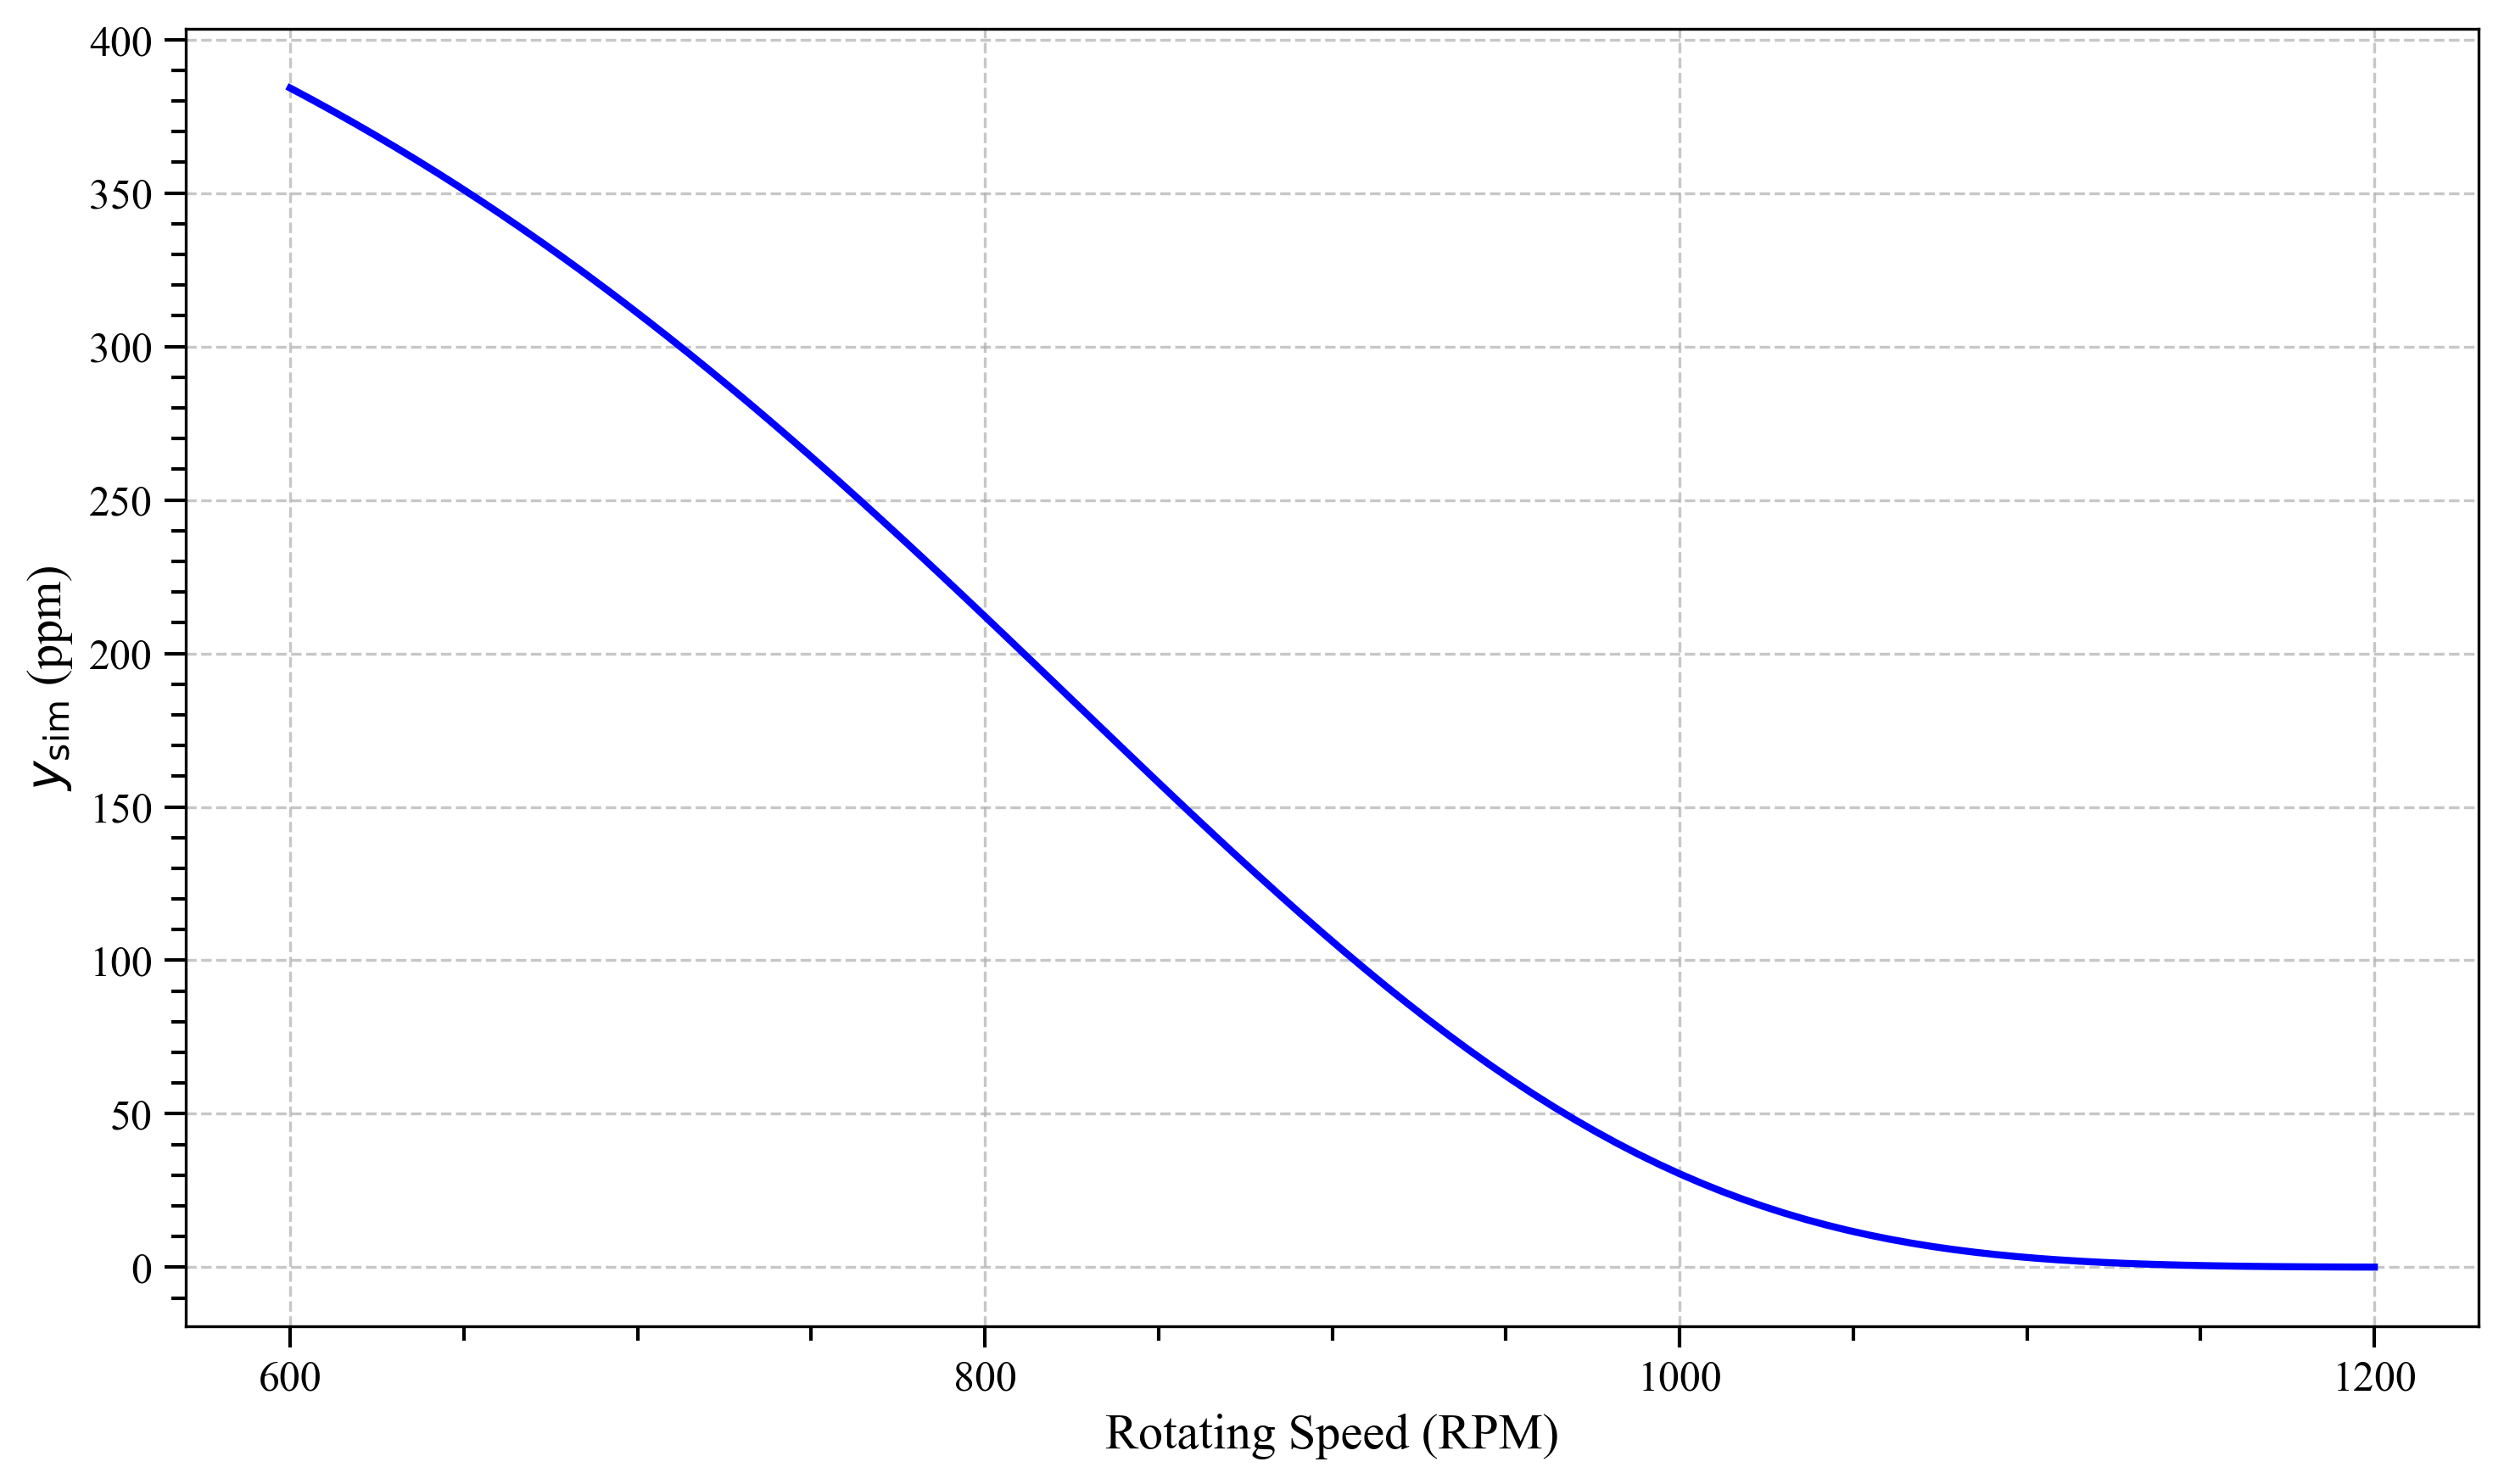

KeyboardInterrupt: 

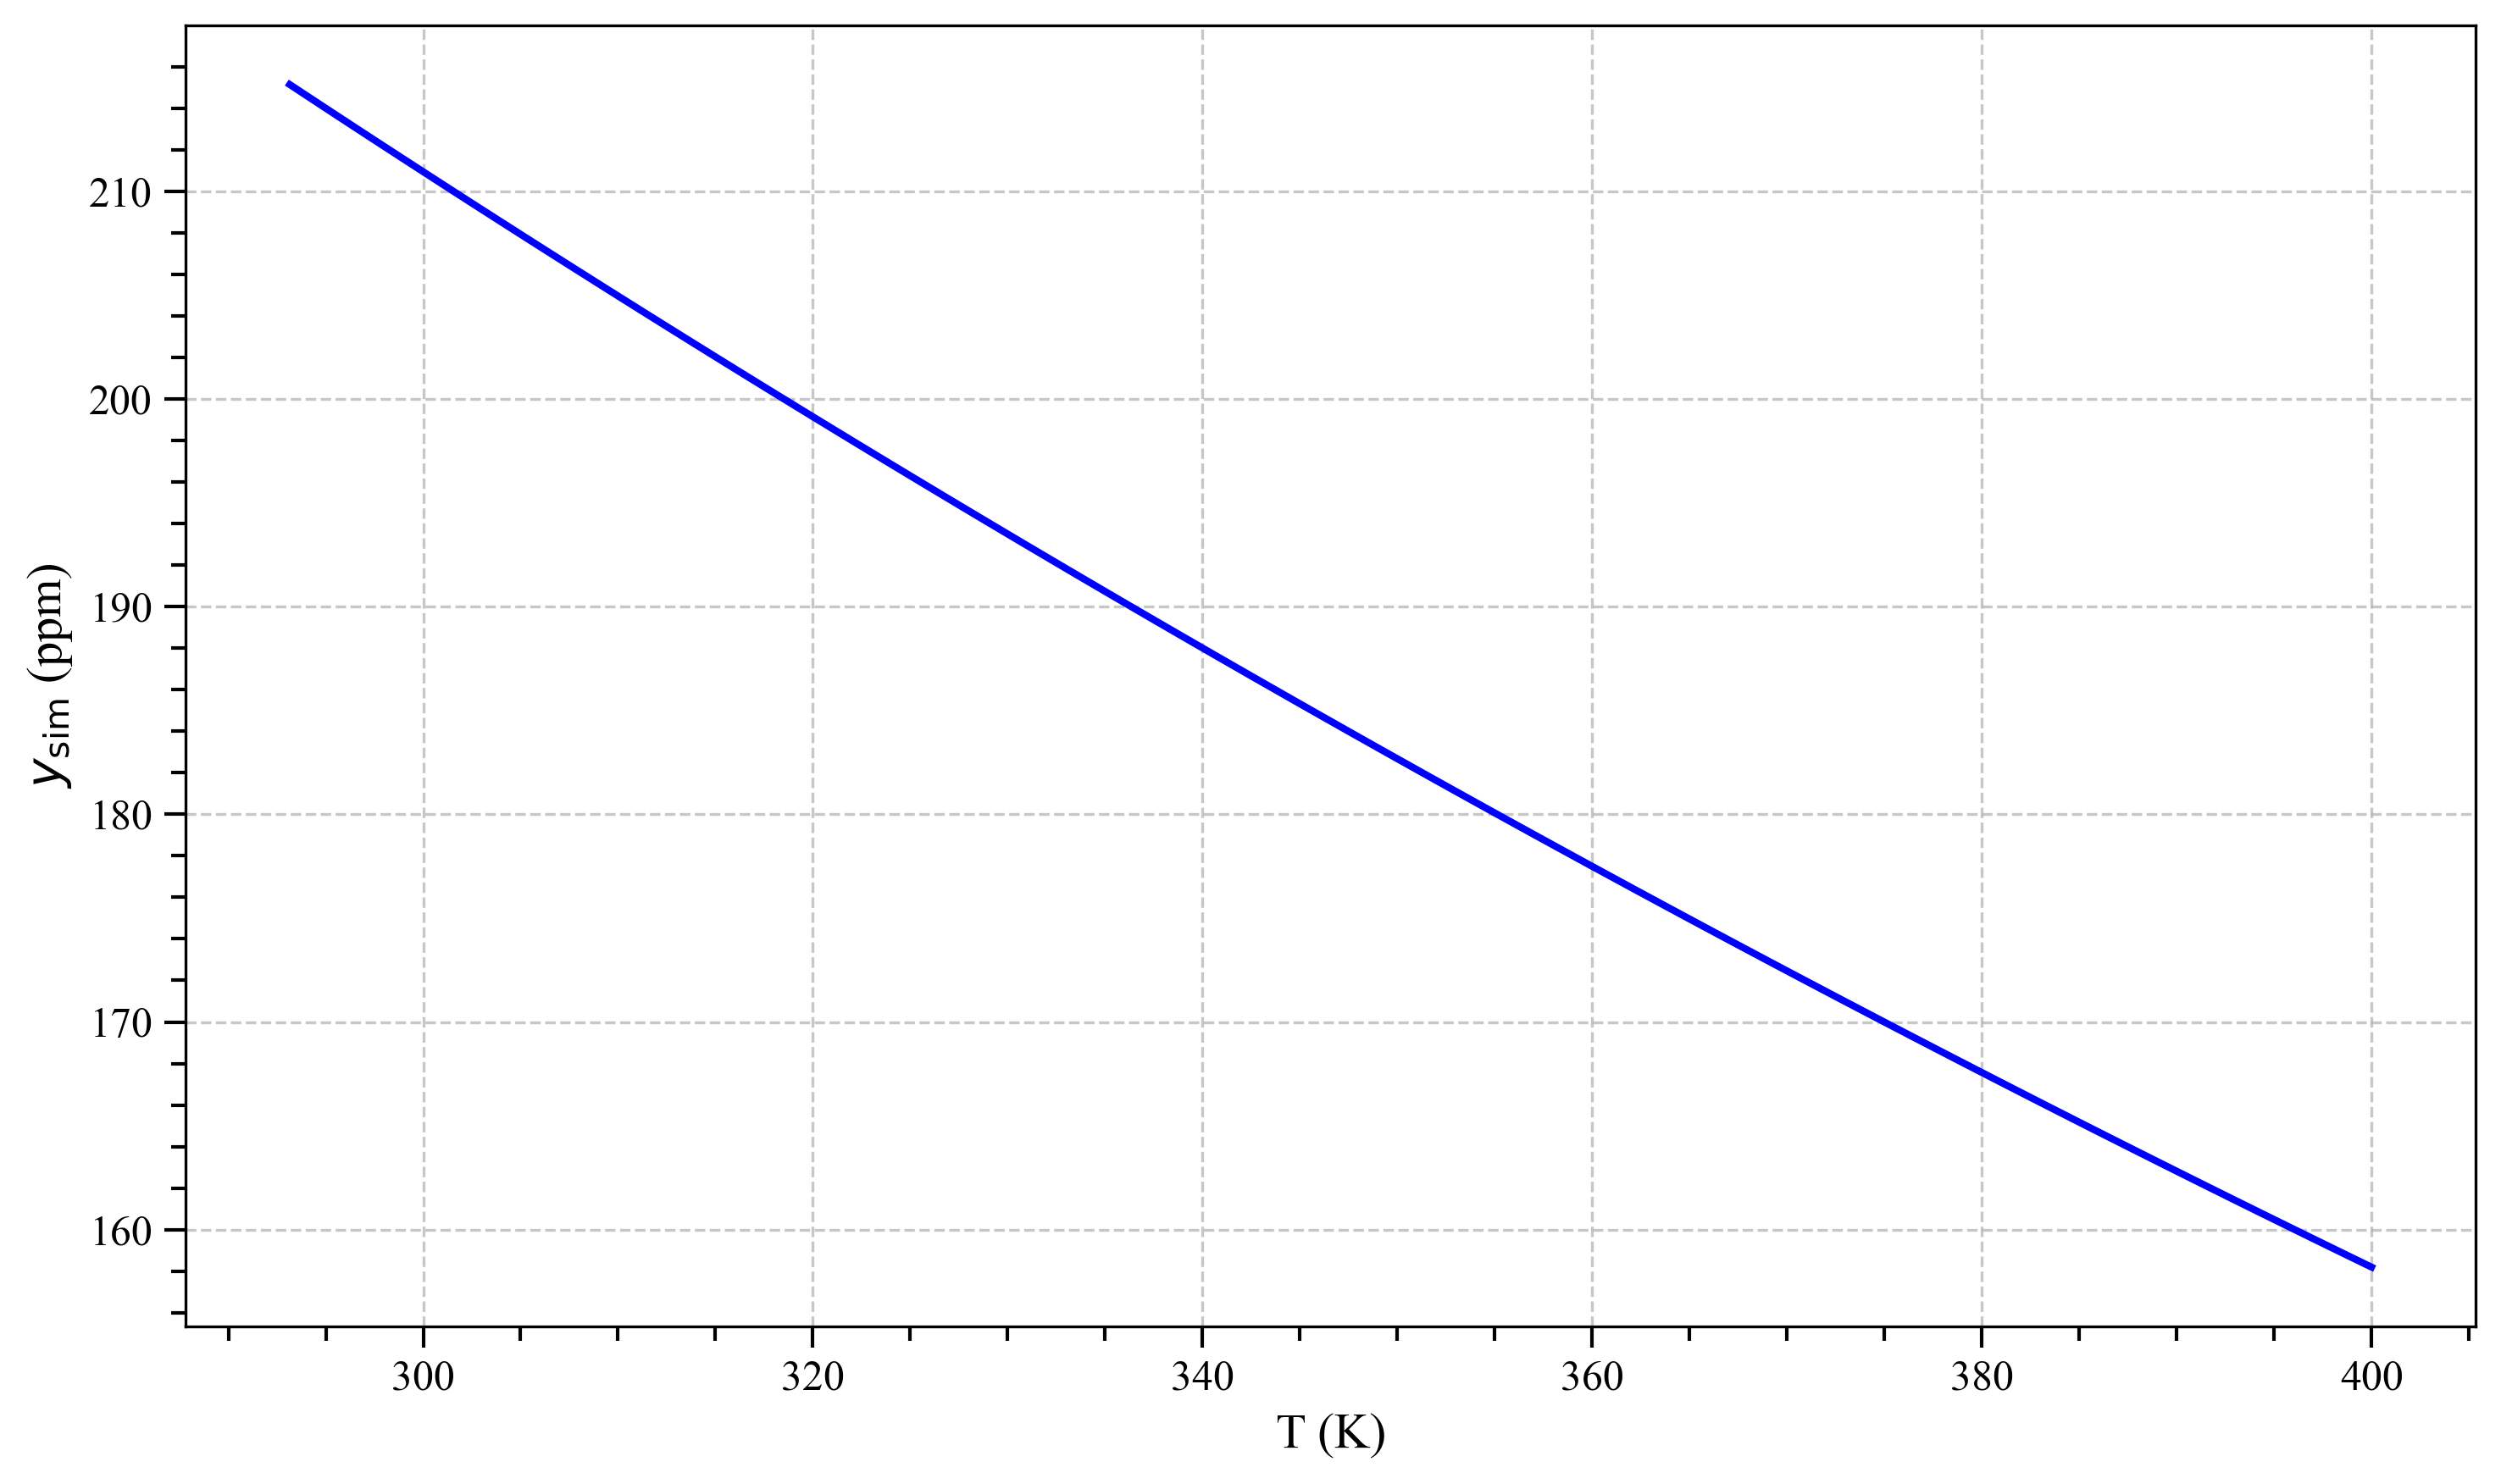

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.special import erf
import math
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, AutoLocator

# 定义函数
def k_ov(w):
    """计算旋转速度w（RPM）下的k_ov值"""
    return 1 * (0.0041 * np.exp(w * np.pi * R / 30) + 0.21746)

def N_chem(c_NO, k_ov, D_NO, bar_t):
    """计算化学通量N_NO"""
    term1 = bar_t * erf(np.sqrt(k_ov * bar_t))
    term2 = np.sqrt(bar_t / (np.pi * k_ov)) * np.exp(-k_ov * bar_t)
    term3 = (1 / (2 * k_ov)) * erf(np.sqrt(k_ov * bar_t))
    return c_NO * np.sqrt(k_ov * D_NO) / bar_t * (term1 + term2 + term3)

def k_L(N_chem, c_NO_star, c_NO_0):
    """计算传质系数k_L"""
    return N_chem / (c_NO_star - c_NO_0)

def bar_t(R_out, R_in, L, w, R, N_S):
    """计算平均停留时间bar_t"""
    return (R_out - R_in) / (0.0217 * L**0.2279 * (w * R)**0.5448 * N_S)

def y_sim(y_in, k_L, T, p_NO, H_NO, alpha, pi, h, R_out, R_in, G_N2):
    """计算模拟出口浓度y_sim"""
    exponent = k_L * 0.082 * T * p_NO / H_NO * alpha * pi * h * (R_out**2 - R_in**2) / G_N2
    return y_in / ((1 - y_in) * np.exp(exponent) + y_in)



# 常数和初始参数
D_NO = 2.5e-9        # NO的扩散系数 (m²/s)
c_NO_star = 500e-6      # NO的平衡浓度 (ppm)
c_NO_0 = 0           # 液相中初始NO浓度 (ppm)
N_S = 100            # 网格数
R_in = 0.015         # 内半径 (m)
R_out = 0.85         # 外半径 (m)
R = np.sqrt(R_out * R_in)  # 平均半径 (m)
h = 0.033            # 高度 (m)
# p_NO = (500 / 1e6) * 101.325  # NO的分压 (atm)
p_NO = (500e-6) * 101.325  # NO的分压 (atm)
H_NO = 375.28        # NO的亨利常数
G_N2 = 5.56e-4       # 气体流量 (m³/s)
y_in = 500e-6           # 入口NO浓度 (ppm)
alpha = 500          # 比表面积 (m²/m³)

# 设置全局字体和字号
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12  # 全局字体大小

# 情况一：改变转速 w 从 600 到 1200 RPM
w_values = np.linspace(600, 1200, 100)
T_fixed = 298.15     # 固定温度 (K)
GLR_fixed = 100      # 固定气液比
L_fixed = G_N2 / GLR_fixed  # 对应的液体流量 (m³/s)
y_sim_w = []

for w in w_values:
    k_ov_val = k_ov(w+400)
    bar_t_val = bar_t(R_out, R_in, L_fixed, w+300, R, N_S)
    N_chem_val = N_chem(y_in, k_ov_val, D_NO, bar_t_val)
    k_L_val = k_L(N_chem_val, c_NO_star, c_NO_0)
    y_sim_val = 1e6 * y_sim(y_in, k_L_val, T_fixed, p_NO, H_NO, alpha, np.pi, h, R_out, R_in, G_N2)
    y_sim_w.append(y_sim_val)

# 绘图
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(w_values, y_sim_w, color='b', linewidth=2)
plt.xlabel('Rotating Speed (RPM)', fontsize=14)
plt.ylabel('$y_{\mathrm{sim}}$ (ppm)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# 设置刻度朝外
plt.tick_params(axis='both', which='major', direction='out', length=6, width=1)
plt.tick_params(axis='both', which='minor', direction='out', length=4, width=1)

# 设置主、副刻度
plt.gca().xaxis.set_major_locator(MultipleLocator(200))  # 主刻度间隔
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())  # 副刻度
plt.gca().yaxis.set_major_locator(AutoLocator())  # 主刻度间隔
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())  # 副刻度

plt.tight_layout()
plt.savefig('y_sim_w.pdf', format='pdf', bbox_inches='tight')
plt.savefig('y_sim_w.png', dpi=2400, bbox_inches='tight')
plt.show()

# 情况二：改变温度 T，从293.15到400 K
T_values = np.linspace(293.15, 400, 100)
w_fixed = 1200       # 固定转速 (RPM)
GLR_fixed = 100      # 固定气液比
L_fixed = G_N2 / GLR_fixed  # 对应的液体流量 (m³/s)
y_sim_T = []
effect_T = []

for T in T_values:
    k_ov_val = k_ov(w_fixed)
    bar_t_val = bar_t(R_out, R_in, L_fixed, w_fixed, R, N_S)
    N_chem_val = N_chem(y_in, k_ov_val, D_NO, bar_t_val)
    k_L_val = k_L(N_chem_val, c_NO_star, c_NO_0)
    y_sim_val = 1e6 * y_sim(y_in, k_L_val, T, p_NO, H_NO, alpha, np.pi, h, R_out, R_in, G_N2)
    y_sim_T.append(y_sim_val)
    effect_T.append((y_in - y_sim_val) / y_in)  # 计算脱除效率
    
    

# 绘制 y_sim 对 T 的图像
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(T_values, y_sim_T, color='b', linewidth=2)
plt.xlabel('T (K)', fontsize=14)
plt.ylabel('$y_{\mathrm{sim}}$ (ppm)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# 设置刻度朝外
plt.tick_params(axis='both', which='major', direction='out', length=6, width=1)
plt.tick_params(axis='both', which='minor', direction='out', length=4, width=1)

# 设置主、副刻度
plt.gca().xaxis.set_major_locator(MultipleLocator(20))  # 主刻度间隔
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())  # 副刻度
plt.gca().yaxis.set_major_locator(AutoLocator())  # 主刻度间隔
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())  # 副刻度

plt.tight_layout()
plt.savefig('y_sim_T.pdf', format='pdf', bbox_inches='tight')
plt.savefig('y_sim_T.png', dpi=2400, bbox_inches='tight')
plt.show()

# 情况三：改变气液比 GLR，从50到150
GLR_values = np.linspace(50, 300, 100)
w_fixed = 1000       # 固定转速 (RPM)
T_fixed = 298.15     # 固定温度 (K)
y_sim_GLR = []
effect_GLR = []

for GLR in GLR_values:
    L = G_N2 / GLR   # 根据气液比调整液体流量
    k_ov_val = k_ov(w_fixed)
    bar_t_val = bar_t(R_out, R_in, L, w_fixed, R, N_S)
    N_chem_val = N_chem(y_in, k_ov_val, D_NO, bar_t_val)
    k_L_val = k_L(N_chem_val, c_NO_star, c_NO_0)
    y_sim_val = 1e6 * y_sim(y_in, k_L_val, T_fixed, p_NO, H_NO, alpha, np.pi, h, R_out, R_in, G_N2)
    y_sim_GLR.append(y_sim_val-200)
    effect_GLR.append((y_in - y_sim_val) / y_in)  # 计算脱除效率

# 绘制 y_sim 和 effect 对 GLR 的图像
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)

# 绘制左侧 y 轴上的 y_sim 曲线
ax1.plot(GLR_values, y_sim_GLR, 'b-', linewidth=2)
ax1.set_xlabel('G/L',fontsize=14)  # X轴标签
ax1.set_ylabel('$y_{\mathrm{sim}}$ (ppm)',fontsize=14)  # Y轴标签
ax1.tick_params(axis='y')  # 设置左侧 y 轴的颜色
ax1.grid(True, linestyle='--', alpha=0.7)

# 设置刻度朝外
ax1.tick_params(axis='both', which='major', direction='out', length=6, width=1)
ax1.tick_params(axis='both', which='minor', direction='out', length=4, width=1)

# 设置主、副刻度
ax1.xaxis.set_major_locator(MultipleLocator(50))  # 主刻度间隔
ax1.xaxis.set_minor_locator(AutoMinorLocator())  # 副刻度
ax1.yaxis.set_major_locator(AutoLocator())  # 主刻度间隔
ax1.yaxis.set_minor_locator(AutoMinorLocator())  # 副刻度
plt.savefig('y_sim_GLR.pdf', format='pdf', bbox_inches='tight')
plt.savefig('y_sim_GLR.png', dpi=2400, bbox_inches='tight')
fig.tight_layout()

# 情况四：改变气进口浓度 y_in，从100到1000 ppm
y_in_values = np.linspace(100e-6, 1000e-6, 100)
y_in_values_ppm = np.linspace(100, 1000, 100)
w_fixed = 1000       # 固定转速 (RPM)
T_fixed = 298.15     # 固定温度 (K)
G_N2 = 5.56e-4       # 气体流量 (m³/s)
L_fixed = 5.56e-6  # 对应的液体流量 (m³/s)
y_sim_y_in = []

for y_in in y_in_values:
    k_ov_val = k_ov(w_fixed)
    bar_t_val = bar_t(R_out, R_in, L_fixed, w_fixed, R, N_S)
    N_chem_val = N_chem(y_in, k_ov_val, D_NO, bar_t_val)
    k_L_val = k_L(N_chem_val, c_NO_star, c_NO_0)
    y_sim_val = 1e6 * y_sim(y_in, k_L_val, T_fixed, p_NO, H_NO, alpha, np.pi, h, R_out, R_in, G_N2)-60
    y_sim_y_in.append(y_sim_val)

# 绘制 y_sim 对 y_in 的图像
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(y_in_values_ppm, y_sim_y_in, color='b',linewidth=2)
plt.xlabel('$y_{\mathrm{in}}$ (ppm)', fontsize=14)
plt.ylabel('$y_{\mathrm{sim}}$ (ppm)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# 设置刻度朝外
plt.tick_params(axis='both', which='major', direction='out', length=6, width=1)
plt.tick_params(axis='both', which='minor', direction='out', length=4, width=1)

# 设置主、副刻度
plt.gca().xaxis.set_major_locator(MultipleLocator(200))  # 主刻度间隔
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())  # 副刻度
plt.gca().yaxis.set_major_locator(AutoLocator())  # 主刻度间隔
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())  # 副刻度

plt.tight_layout()
plt.savefig('y_sim_y_in.pdf', format='pdf', bbox_inches='tight')
plt.savefig('y_sim_y_in.png', dpi=2400, bbox_inches='tight')
plt.show()
